MARKOV ICL - CLASSIFICATION (Softmax Output)
K=32, D=1, N=3, B=1, nodes=3
Method: direct_solve, Temperature: 1.0
Device: cpu

Creating GMM with discrete labels...
  GMM: 32 classes with labels randomly assigned from {1, ..., 32}
  First 10 class labels: [ 7. 27. 14. 12. 27. 26.  4. 11. 12. 30.]

Generating data...

Creating model...
  Initialized ICL Attention model (L=32 classes, attention over 3 context items)
  Label modulation: False
  Base rates learnable: False
  Parameters: 45

Training...
Epoch  10 | Train: 99.45% | Val: 99.30% | IWL: 5.80% | ICL: 99.60%
Epoch  20 | Train: 99.79% | Val: 99.80% | IWL: 6.80% | ICL: 100.00%
Epoch  30 | Train: 99.88% | Val: 99.80% | IWL: 9.20% | ICL: 100.00%
Epoch  40 | Train: 99.90% | Val: 99.90% | IWL: 7.20% | ICL: 100.00%
Epoch  50 | Train: 99.91% | Val: 100.00% | IWL: 8.80% | ICL: 100.00%
Epoch  60 | Train: 99.92% | Val: 100.00% | IWL: 6.60% | ICL: 99.80%
Epoch  70 | Train: 99.91% | Val: 100.00% | IWL: 7.60% | ICL: 100.00%
Epoch  80 | Train: 99

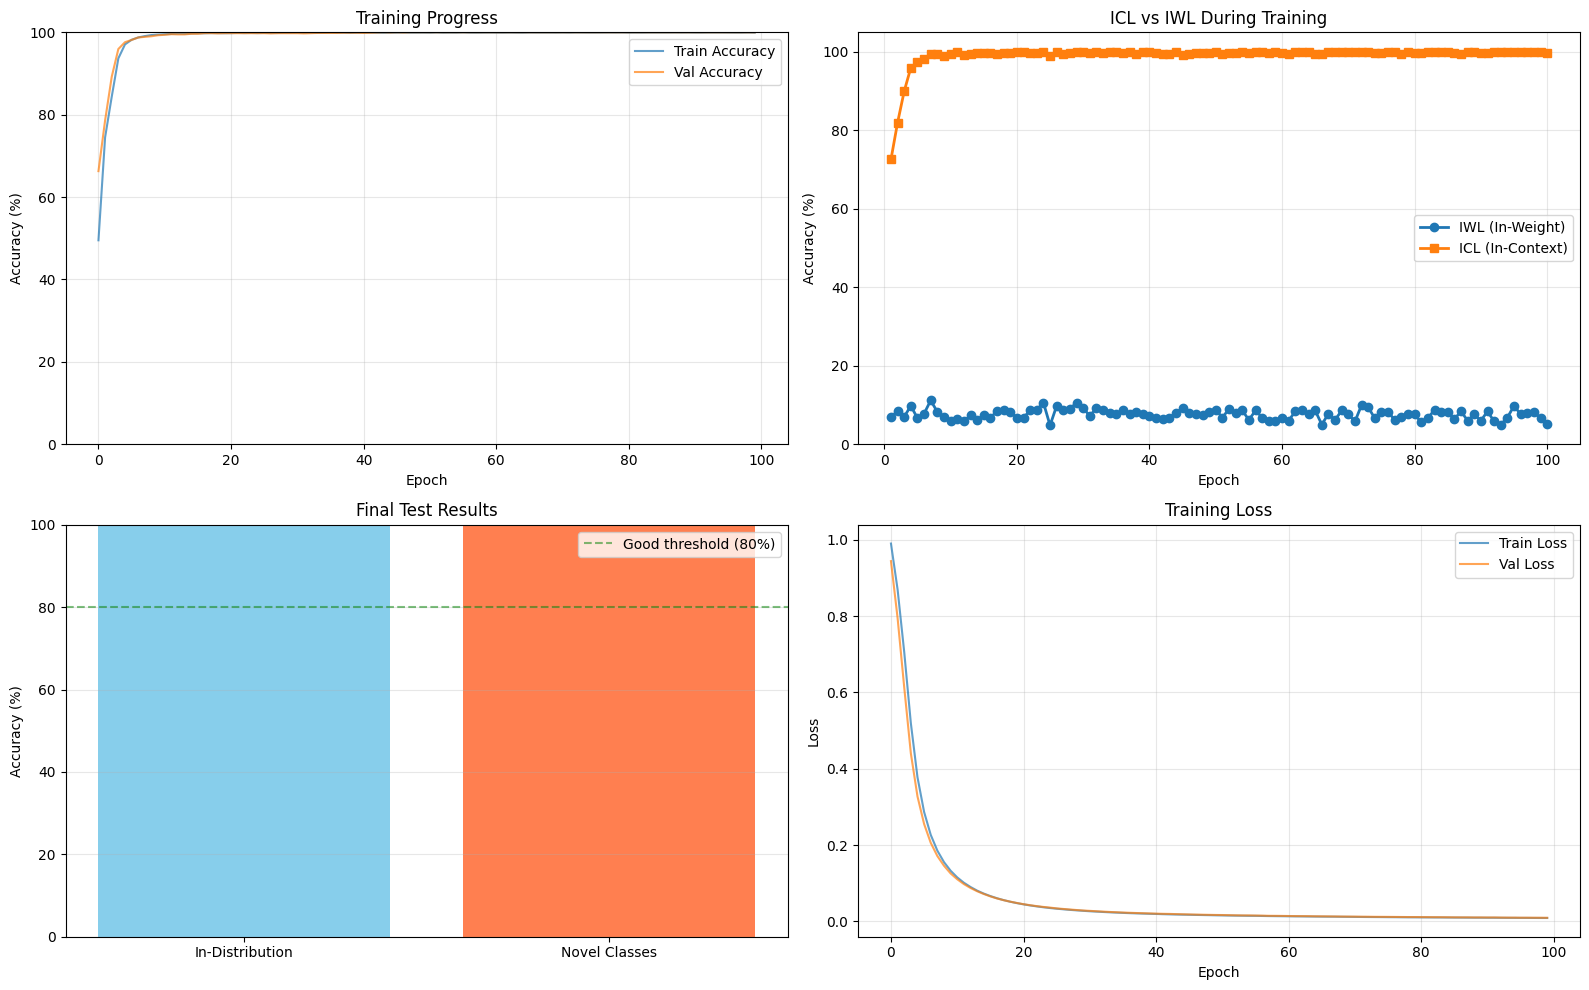


ICL/IWL SUMMARY
Final IWL Accuracy:        5.20%
Final ICL Accuracy:  99.80%


In [2]:
### Updated to use refactored code structure

# Import from refactored modules
import torch
import numpy as np
import os
import time
from torch.utils.data import DataLoader

# Import from new modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data, generate_iwl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL, RandomPolynomialICL
from training import train_model
from evaluation import test_icl
from config import ExperimentConfig

L = 32
K = 32
D = 1
N = 3
B = 1
n_nodes = 3
epochs = 100
lr = 0.001
batch_size = 32
train_samples = 10000
val_samples = 2000
epsilon = 1e-6
seed = 20
exact_copy = True
method = 'direct_solve'
temperature = 1.0
shuffle_context = True
learn_base_rates = False
offset = 0.0
min_max_choice = "max"

# Set parameters
params = {
    'K': K,                      # Number of GMM classes
    'L': L,                      # Number of output classes (can be different from K)
    'D': D,                      # Dimension
    'N': N,                      # Context examples
    'B': B,                      # Burstiness
    'n_nodes': n_nodes,          # Markov nodes
    'epochs': epochs,            # Training epochs
    'lr': lr,                    # Learning rate
    'batch_size': batch_size,
    'train_samples': train_samples,
    'val_samples': val_samples,
    'epsilon': epsilon,          # Within-class noise
    'seed': seed,
    'exact_copy': exact_copy,    # Query is exact copy of context item
    'method': method,
    'temperature': temperature,   # Softmax temperature
    'shuffle_context': shuffle_context,
    'learn_base_rates': learn_base_rates,
    'offset': offset,
    'min_max_choice': min_max_choice
}



print("="*70)
print("MARKOV ICL - CLASSIFICATION (Softmax Output)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print(f"Method: {params['method']}, Temperature: {params['temperature']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM with discrete labels (1 to L)
print("Creating GMM with discrete labels...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], L=params['L'], epsilon=params['epsilon'], seed=params['seed'], offset=params['offset'])
print(f"  GMM: {params['K']} classes with labels randomly assigned from {{1, ..., {params['L']}}}")
print(f"  First 10 class labels: {gmm.class_to_label[:min(10, params['K'])].numpy()}")

# Generate data
print("\nGenerating data...")
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'])
val_data = generate_icl_gmm_data(gmm, params['val_samples'], params['N'], 
                                 novel_classes=False, exact_copy=params['exact_copy'], 
                                 B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ICLGMMDataset(val_data), batch_size=params['batch_size'],
                       collate_fn=collate_fn)

# Create model
print("\nCreating model...")
model = MatrixTreeMarkovICL(n_nodes=params['n_nodes'], z_dim=params['D'], 
                           L=params['L'], N=params['N'], learn_base_rates=params['learn_base_rates'])

# Train with ICL/IWL tracking
start_time = time.time()
print("\nTraining...")
print("="*70)
history = train_model(model, train_loader, val_loader, device, 
                     n_epochs=params['epochs'], lr=params['lr'], 
                     method=params['method'], temperature=params['temperature'],
                     gmm=gmm, N=params['N'], B=params['B'], 
                     L=params['L'], exact_copy=params['exact_copy'],
                     eval_frequency=1, n_eval_samples=500, min_max_choice=params['min_max_choice'])
                     
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test
results = test_icl(model, gmm, params['N'], device, n_samples=1000, 
                  exact_copy=params['exact_copy'], B=params['B'], 
                  method=params['method'], L=params['L'],
                  temperature=params['temperature'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'])

# # Save model
# os.makedirs('results', exist_ok=True)
# model_path = f'results/markov_icl_gmm_K{config.K}_N{config.N}_classification_T{config.temperature:.1f}.pt'
# torch.save(model.state_dict(), model_path)
# print(f"\n✓ Saved: {model_path}")

# Plot training history with ICL/IWL metrics
try:
    import matplotlib.pyplot as plt
    
    # Extract ICL/IWL metrics (filter out None values)
    epochs_eval = [i+1 for i, val in enumerate(history['iwl_acc']) if val is not None]
    iwl_acc = [val for val in history['iwl_acc'] if val is not None]
    icl_acc = [val for val in history['icl_acc'] if val is not None]
    #icl_swap_acc = [val for val in history['icl_swap_acc'] if val is not None]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Training/Val Accuracy
    ax1 = axes[0, 0]
    ax1.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    ax1.plot(history['val_acc'], label='Val Accuracy', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    
    # Plot 2: ICL vs IWL over time
    ax2 = axes[0, 1]
    if len(iwl_acc) > 0:
        ax2.plot(epochs_eval, iwl_acc, 'o-', label='IWL (In-Weight)', linewidth=2, markersize=6)
        ax2.plot(epochs_eval, icl_acc, 's-', label='ICL (In-Context)', linewidth=2, markersize=6)
        #ax2.plot(epochs_eval, icl_swap_acc, '^-', label='ICL Label Swap', linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('ICL vs IWL During Training')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 105])
    else:
        ax2.text(0.5, 0.5, 'No ICL/IWL data\n(set gmm parameter)', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Plot 3: Final test results
    ax3 = axes[1, 0]
    ax3.bar(['In-Distribution', 'Novel Classes'], 
            [results['in_dist'], results['novel_classes']],
            color=['skyblue', 'coral'])
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Final Test Results')
    ax3.axhline(y=80, color='g', linestyle='--', label='Good threshold (80%)', alpha=0.5)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 100])
    
    # Plot 4: Training/Val Loss
    ax4 = axes[1, 1]
    ax4.plot(history['train_loss'], label='Train Loss', alpha=0.7)
    ax4.plot(history['val_loss'], label='Val Loss', alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.set_title('Training Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if len(iwl_acc) > 0:
        print("\n" + "="*70)
        print("ICL/IWL SUMMARY")
        print("="*70)
        print(f"Final IWL Accuracy:        {iwl_acc[-1]:.2f}%")
        print(f"Final ICL Accuracy:  {icl_acc[-1]:.2f}%")
        #print(f"Final ICL Swap Accuracy:   {icl_swap_acc[-1]:.2f}%")
        print("="*70)
    
except ImportError:
    print("\n(Install matplotlib to see training plots)")

In [2]:
import plotly.graph_objects as go
import numpy as np

# Get one batch for context, but only plotting A and B vectors
z_seq, labels, targets = train_loader.dataset[100]
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
print(z_flat)
z_flat = torch.tensor([[-2, 1, -2]], dtype=torch.float32)
print(z_flat)

# Compute the rate matrix K
model.eval()
with torch.no_grad():
    K_mat = model.compute_rate_matrix_K(z_flat)

p_steady = model.matrix_tree_steady_state(K_mat)
print(p_steady)

p_steady = model.direct_solve_steady_state(K_mat) 
print(p_steady)

# Calculate vectors A and B
one_inds = [0,1]
two_inds = [1,0]
A = model.K_params[one_inds[0],one_inds[1],:].detach().numpy() 
B = model.K_params[two_inds[0],two_inds[1],:].detach().numpy() 

# Optional: Show softmax weights
piA = np.exp(z_flat @ A) 
piB = np.exp(z_flat @ B) 
Z = piA + piB
piAf = (piA / Z).item()
piBf = (piB / Z).item()
print([piAf, piBf])

# Plot ONLY A and B as 3D arrows
vectors = {
    'A': A,
    'B': B,
}
colors = {
    'A': 'red',
    'B': 'blue'
}
fig = go.Figure()

def add_arrow(fig, start, end, color, name, width=5):
    if name is None:
        showlegend = False
    else:
        showlegend = True   
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width),
        name=name,
        showlegend=showlegend
    ))
    fig.add_trace(go.Cone(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        u=[end[0] - start[0]],
        v=[end[1] - start[1]],
        w=[end[2] - start[2]],
        colorscale=[[0, color], [1, color]],
        showscale=False,
        sizemode='absolute',
        sizeref=0.06,
        name=name,
        showlegend=False
    ))

origin = np.array([0, 0, 0])
for name, vec in vectors.items():
    letter = name[0]
    color = colors[letter]
    add_arrow(fig, origin, vec, color, name, width=1)

# Set plot limits for better visualization
max_range = np.max(np.abs(np.array([A, B])))
max_range = 8
fig.update_layout(
    title='3D Vectors A and B',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(range=[-max_range, max_range]),
        yaxis=dict(range=[-max_range, max_range]),
        zaxis=dict(range=[-max_range, max_range]),
        aspectmode='cube',
        camera=dict(
            eye=dict(x=-1.5, y=-1.5, z=0)
        )
    ),
    width=800,
    height=600,
    showlegend=True
)

v1 = np.array([0, 1, 1])
v2 = np.array([1, 0, 0])

# max_range = np.array([
#     max(abs(v[0]) for v in vectors.values()),
#     max(abs(v[1]) for v in vectors.values()),
#     max(abs(v[2]) for v in vectors.values())
# ]).max()

t1 = np.linspace(-max_range, max_range, 20)
t2 = np.linspace(-max_range, max_range, 20)
T1, T2 = np.meshgrid(t1, t2)

X_plane1 = T2 * v2[0] + T1 * v1[0]
Y_plane1 = T2 * v2[1] + T1 * v1[1]
Z_plane1 = T2 * v2[2] + T1 * v1[2]

fig.add_trace(go.Surface(
    x=X_plane1, y=Y_plane1, z=Z_plane1,
    opacity=0.3,
    colorscale=[[0, 'magenta'], [1, 'magenta']],
    showscale=False,
    name='Plane 1',
    showlegend=True
))

# Create plane 2: spanned by {1,0,1} and {0,1,0}
v1 = np.array([1, 0, 1])
v2 = np.array([0, 1, 0])

X_plane2 = T2 * v2[0] + T1 * v1[0]
Y_plane2 = T2 * v2[1] + T1 * v1[1]
Z_plane2 = T2 * v2[2] + T1 * v1[2]

fig.add_trace(go.Surface(
    x=X_plane2, y=Y_plane2, z=Z_plane2,
    opacity=0.3,
    colorscale=[[0, 'cyan'], [1, 'cyan']],
    showscale=False,
    name='Plane 2',
    showlegend=True
))

# Prepare data for 3D scatter plot from first 100 data points, plotting first three (A, B, C) feature values for each.
scatter_x, scatter_y, scatter_z = [], [], []
colors = []
for i in range(100):
    # Get one batch for context, but only plotting A and B vectors
    z_seq, labels, targets = train_loader.dataset[i]
    z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
    z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
    scatter_x.append(z_flat[0,0])
    scatter_y.append(z_flat[0,1])
    scatter_z.append(z_flat[0,2])
    if targets.item() == labels[0].item():
        colors.append('cyan')
    elif targets.item() == labels[1].item():
        colors.append('magenta')

fig.add_trace(go.Scatter3d(
    x=scatter_x, y=scatter_y, z=scatter_z,
    mode='markers',
    marker=dict(size=2, color=colors, opacity=0.8),
    name='Data pts'
))


fig.show()

tensor([[-0.4471, -0.2625, -0.2625]])
tensor([[-2.,  1., -2.]])
tensor([[1.0000e+00, 1.4463e-09]])
tensor([[1.0000e+00, 1.4463e-09]])
[1.0, 1.4463077402382396e-09]


In [29]:
gmm.class_means

tensor([[ 0.4896],
        [ 0.5672],
        [ 1.5507],
        [-0.3583],
        [ 0.6792],
        [-0.0396],
        [-0.1380],
        [-0.4471],
        [ 1.1870],
        [-0.2625],
        [ 0.9833],
        [ 0.8193],
        [-0.2575],
        [ 1.7480],
        [-1.9582],
        [-0.1159],
        [-1.0149],
        [ 0.2608],
        [-0.5658],
        [-0.0039],
        [-1.5368],
        [ 0.1338],
        [-1.9384],
        [ 0.6464],
        [ 0.3374],
        [ 1.0499],
        [-1.2826],
        [-0.2780],
        [ 0.3670],
        [-0.8730],
        [ 1.6860],
        [ 0.3176]])

In [27]:
z_seq, labels, targets = train_loader.dataset[0]
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)

if targets.item() == labels[0].item():
    print("Correct")
elif targets.item() == labels[1].item():
    print("2")


2


In [24]:
labels[0].item()

11.0

In [6]:
max_range

0.06028987

In [ ]:
import plotly.graph_objects as go
import numpy as np

## need jupyter notebook renderer
### plot data distribution here too 

z_seq, labels, targets = train_loader.dataset[100]

# Add batch dimension and move to device
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)


z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
print(z_flat)
z_flat = torch.tensor([[-2, 1, -2]], dtype=torch.float32)
print(z_flat)
# Compute the rate matrix K
model.eval()
with torch.no_grad():
    K_mat = model.compute_rate_matrix_K(z_flat)
# Verify that columns sum to approximately zero (as they should for a rate matrix)
col_sums = K_mat[0].sum(dim=0)
# p_steady = model.direct_solve_steady_state(K_mat)

p_steady = model.matrix_tree_steady_state(K_mat)
print(p_steady)

p_steady = model.direct_solve_steady_state(K_mat) 
print(p_steady)

# Compute the inner product z_flat @ Amat @ z_flat^T
# z_flat shape: (1, (N+1)*D)
# Amat shape: ((N+1)*D, (N+1)*D)

one_inds = [0,2]
two_inds = [2,1]
three_inds = [0,1]
four_inds = [1,2]
five_inds = [1,0]
six_inds = [2,0]


A1 = model.K_params[one_inds[0],one_inds[1],:].detach().numpy() + model.K_params[two_inds[0],two_inds[1],:].detach().numpy() 
A2 = model.K_params[three_inds[0],three_inds[1],:].detach().numpy() + model.K_params[four_inds[0],four_inds[1],:].detach().numpy()
A3 = model.K_params[one_inds[0],one_inds[1],:].detach().numpy() + model.K_params[three_inds[0],three_inds[1],:].detach().numpy()
B1 = model.K_params[five_inds[0],five_inds[1],:].detach().numpy() + model.K_params[one_inds[0],one_inds[1],:].detach().numpy()
B2 = model.K_params[four_inds[0],four_inds[1],:].detach().numpy() + model.K_params[six_inds[0],six_inds[1],:].detach().numpy()
B3 = model.K_params[four_inds[0],four_inds[1],:].detach().numpy() + model.K_params[five_inds[0],five_inds[1],:].detach().numpy()
C1 = model.K_params[six_inds[0],six_inds[1],:].detach().numpy() + model.K_params[three_inds[0],three_inds[1],:].detach().numpy()
C2 = model.K_params[five_inds[0],five_inds[1],:].detach().numpy() + model.K_params[two_inds[0],two_inds[1],:].detach().numpy()
C3 = model.K_params[six_inds[0],six_inds[1],:].detach().numpy() + model.K_params[two_inds[0],two_inds[1],:].detach().numpy()


piA = np.exp(z_flat @ A1) + np.exp(z_flat @ A2) + np.exp(z_flat @ A3)
piB = np.exp(z_flat @ B1) + np.exp(z_flat @ B2) + np.exp(z_flat @ B3)
piC = np.exp(z_flat @ C1) + np.exp(z_flat @ C2) + np.exp(z_flat @ C3)
Z = piA + piB + piC
piAf = (piA / Z).item()
piBf = (piB / Z).item()
piCf = (piC / Z).item()
print([piAf, piBf, piCf])

# Define vectors (already computed above)
vectors = {
    'A1': A1, 'A2': A2, 'A3': A3,
    'B1': B1, 'B2': B2, 'B3': B3,
    'C1': C1, 'C2': C2, 'C3': C3
}

# Color mapping by letter
colors = {
    'A': 'red',
    'B': 'blue',
    'C': 'green'
}

# Create figure
fig = go.Figure()

# Helper function to create a 3D arrow (cone at tip)
def add_arrow(fig, start, end, color, name, width=5):
    # Line for the arrow shaft
    if name is None:
        showlegend = False
    else:
        showlegend = True   
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width),
        name=name,
        showlegend=showlegend
    ))
    
    # Cone for the arrowhead
    fig.add_trace(go.Cone(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        u=[end[0] - start[0]],
        v=[end[1] - start[1]],
        w=[end[2] - start[2]],
        colorscale=[[0, color], [1, color]],
        showscale=False,
        sizemode='absolute',
        sizeref=0.6,
        name=name,
        showlegend=False
    ))

# Plot each vector as an arrow
origin = np.array([0, 0, 0])
for name, vec in vectors.items():
    letter = name[0]
    color = colors[letter]
    add_arrow(fig, origin, vec, color, name, width=5)


# # Add special vectors for the planes
# add_arrow(fig, origin, np.array([0, 2, 2]), 'magenta', 'Plane 1', width=6)
# add_arrow(fig, origin, np.array([2, 0, 2]), 'cyan', 'Plane 2', width=6)

# Create plane 1: spanned by {0,1,1} and {1,0,0}
v1 = np.array([0, 1, 1])
v2 = np.array([1, 0, 0])

max_range = np.array([
    max(abs(v[0]) for v in vectors.values()),
    max(abs(v[1]) for v in vectors.values()),
    max(abs(v[2]) for v in vectors.values())
]).max()

t1 = np.linspace(-max_range, max_range, 20)
t2 = np.linspace(-max_range, max_range, 20)
T1, T2 = np.meshgrid(t1, t2)

X_plane1 = T2 * v2[0] + T1 * v1[0]
Y_plane1 = T2 * v2[1] + T1 * v1[1]
Z_plane1 = T2 * v2[2] + T1 * v1[2]

fig.add_trace(go.Surface(
    x=X_plane1, y=Y_plane1, z=Z_plane1,
    opacity=0.3,
    colorscale=[[0, 'magenta'], [1, 'magenta']],
    showscale=False,
    name='Plane 1',
    showlegend=True
))

# Create plane 2: spanned by {1,0,1} and {0,1,0}
v1 = np.array([1, 0, 1])
v2 = np.array([0, 1, 0])

X_plane2 = T2 * v2[0] + T1 * v1[0]
Y_plane2 = T2 * v2[1] + T1 * v1[1]
Z_plane2 = T2 * v2[2] + T1 * v1[2]

fig.add_trace(go.Surface(
    x=X_plane2, y=Y_plane2, z=Z_plane2,
    opacity=0.3,
    colorscale=[[0, 'cyan'], [1, 'cyan']],
    showscale=False,
    name='Plane 2',
    showlegend=True
))

# Update layout
fig.update_layout(
    title='3D Vector Visualization with Planes',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(range=[-max_range, max_range]),
        yaxis=dict(range=[-max_range, max_range]),
        zaxis=dict(range=[-max_range, max_range]),
        aspectmode='cube',
        camera=dict(
            eye=dict(x=-1.5, y=-1.5, z=0)  # Change these values to adjust viewpoint
        )
    ),
    width=1000,
    height=800,
    showlegend=True
)

fig.show()

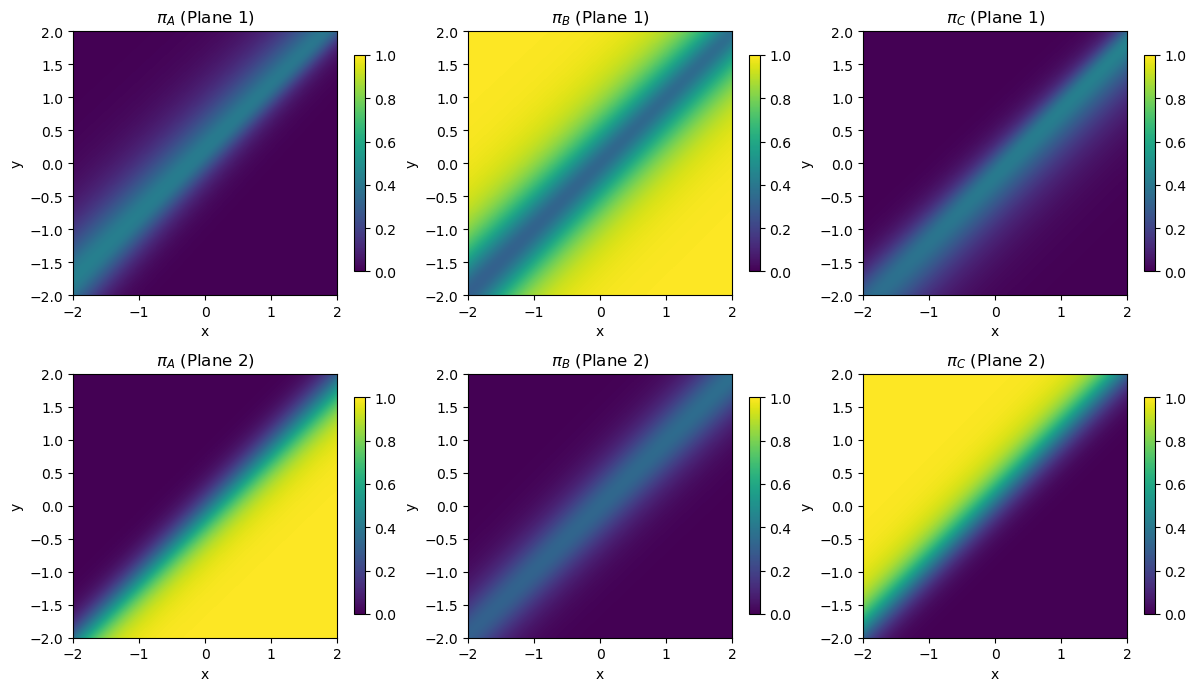

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt

n_coords = 100
rr = 2

# Create 2x3 axes for plotting (two rows for two planes, each with three components)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

x_coords = np.linspace(-rr, rr, n_coords)
y_coords = np.linspace(-rr, rr, n_coords)

basis_options = [
    (np.array([0, 1, 0]), np.array([1, 0, 1])),
    (np.array([1, 0, 0]), np.array([0, 1, 1])),
]

component_titles = [r"$\pi_{A}$", r"$\pi_{B}$", r"$\pi_{C}$"]

for row, (x_basis, y_basis) in enumerate(basis_options):
    # Storage for p_steady components
    p1 = np.zeros((n_coords, n_coords))
    p2 = np.zeros((n_coords, n_coords))
    p3 = np.zeros((n_coords, n_coords))

    model.eval()
    for i, x in enumerate(x_coords):
        for j, y in enumerate(y_coords):
            z_vec = x * x_basis + y * y_basis
            # Ensure correct shape for z_flat: (1, D), where D is the number of features for the model
            # Assume z_vec is already shape (3,), adapt as needed
            if hasattr(model, "input_dim"):
                D = model.input_dim
            else:
                # Try infer D from first layer if possible, or fallback to len(z_vec)
                try:
                    D = model.base_log_rates.shape[-1]
                except Exception:
                    D = len(z_vec)
            z_vec_padded = np.zeros(D)
            z_vec_padded[:len(z_vec)] = z_vec
            z_flat = torch.tensor([z_vec_padded], dtype=torch.float32)
            with torch.no_grad():
                K_mat = model.compute_rate_matrix_K(z_flat)
                p_steady = model.direct_solve_steady_state(K_mat).cpu().numpy().flatten()
            # If p_steady has less than 3 elements, pad with nan
            vals = np.full(3, np.nan)
            vals[:min(3, len(p_steady))] = p_steady[:min(3, len(p_steady))]
            p1[j, i] = vals[0]
            p2[j, i] = vals[1]
            p3[j, i] = vals[2]

    comps = [p1, p2, p3]
    for col, (data, title) in enumerate(zip(comps, component_titles)):
        ax = axes[row, col]
        im = ax.imshow(
            data,
            extent=(x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]),
            origin="lower",
            interpolation="bilinear",
            vmin=0,
            vmax=1,
            aspect="equal",
        )
        ax.set_title(title + f" (Plane {row+1})")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(im, ax=ax, shrink=0.75)

plt.tight_layout()
plt.show()


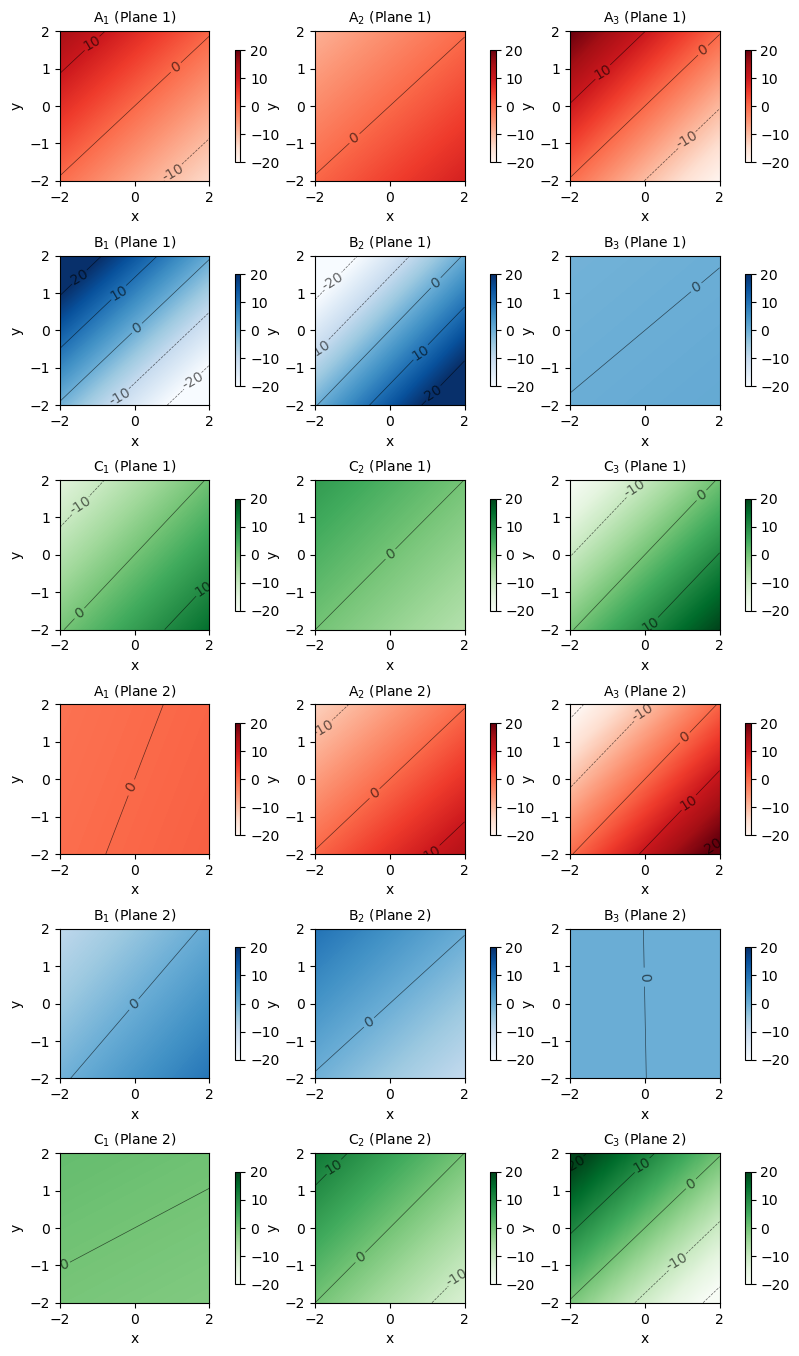

In [71]:
import numpy as np
import torch
import matplotlib.pyplot as plt

n_coords = 100
rr = 2
vrange = 20

# We'll plot: [A1,A2,A3, B1,B2,B3, C1,C2,C3] for each plane, so 6 rows x 3 columns (2 planes × 3 vectors per block)
# The arrangement will be:
#   [A1_plane1, A2_plane1, A3_plane1]
#   [B1_plane1, B2_plane1, B3_plane1]
#   [C1_plane1, C2_plane1, C3_plane1]
#   [A1_plane2, A2_plane2, A3_plane2]
#   [B1_plane2, B2_plane2, B3_plane2]
#   [C1_plane2, C2_plane2, C3_plane2]

fig, axes = plt.subplots(6, 3, figsize= 0.75 * np.array((14, 18)))

x_coords = np.linspace(-rr, rr, n_coords)
y_coords = np.linspace(-rr, rr, n_coords)

basis_options = [
    (np.array([0, 1, 0]), np.array([1, 0, 1])),
    (np.array([1, 0, 0]), np.array([0, 1, 1])),
]

names = [r"A$_1$", r"A$_2$", r"A$_3$", r"B$_1$", r"B$_2$", r"B$_3$", r"C$_1$", r"C$_2$", r"C$_3$"]
vectors = [lambda z: A1 @ z, lambda z: A2 @ z, lambda z: A3 @ z,
           lambda z: B1 @ z, lambda z: B2 @ z, lambda z: B3 @ z,
           lambda z: C1 @ z, lambda z: C2 @ z, lambda z: C3 @ z]


for plane_idx, (x_basis, y_basis) in enumerate(basis_options):
    # Compute 9 arrays for this plane
    value_arrays = []
    for vec_idx in range(9):
        values = np.zeros((n_coords, n_coords))
        func = vectors[vec_idx]
        for i, x in enumerate(x_coords):
            for j, y in enumerate(y_coords):
                z_vec = x * x_basis + y * y_basis
                values[j, i] = func(z_vec)
        value_arrays.append(values)
    # Plot each array in its spot: row_offset = (0 for plane1, 3 for plane2)
    row_offset = plane_idx * 3
    for local_row in range(3):  # A/B/C
        if local_row == 0:
            cmap = 'Reds'
        elif local_row == 1:
            cmap = 'Blues'
        else:
            cmap = 'Greens'
        for col in range(3):    # 1/2/3
            vec_idx = local_row * 3 + col
            ax = axes[row_offset + local_row, col]
            im = ax.imshow(
                value_arrays[vec_idx],
                extent=(x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]),
                origin="lower",
                interpolation="bilinear",
                aspect="equal",
                cmap=cmap,
                vmin=-vrange,
                vmax=vrange
            )

            contours = ax.contour(
                x_coords, y_coords, value_arrays[vec_idx],
                levels=[-20, -10, 0, 10, 20],
                colors='black',
                linewidths=0.5,
                alpha=0.6
            )

            ax.clabel(contours, inline=True, fontsize=10, fmt='%g')
    

            ax.set_title(f"{names[vec_idx]} (Plane {plane_idx+1})", fontsize=10)
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, shrink=0.75)
            # if col == 2:
            #     fig.colorbar(im, ax=ax, shrink=0.75)

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.5, wspace=-0.5)

plt.show()


In [11]:
# Print vectors in Mathematica format
vectors_dict = {
    'A1': A1, 'A2': A2, 'A3': A3,
    'B1': B1, 'B2': B2, 'B3': B3,
    'C1': C1, 'C2': C2, 'C3': C3
}

print("(* Define the vectors *)")
for name, vec in vectors_dict.items():
    # Format as Mathematica list
    mathematica_vec = "{" + ", ".join([f"{v:.10f}" for v in vec]) + "}"
    print(f"{name} = {mathematica_vec};")

(* Define the vectors *)
A1 = {0.3865606785, -3.4139919281, 3.2652401924};
A2 = {3.1193525791, 2.0667195320, -5.3622150421};
A3 = {5.6222887039, -4.8213915825, -0.5888735056};
B1 = {2.4702458382, -6.7159299850, 4.6005187035};
B2 = {-2.3144876957, 7.1673793793, -4.6292409897};
B3 = {-0.0326905847, 0.1721816063, -0.1728229523};
C1 = {-0.2478547096, 3.7221360207, -3.2547476292};
C2 = {-3.2017860413, -1.8656623363, 5.0557837486};
C3 = {-5.4835829735, 5.1295356750, 0.5993660688};


In [7]:
print(model.K_params[0,1])  
print(model.K_params[1,0])
print(model.base_log_rates[0,1])
print(model.base_log_rates[1,0])
print(val_data[0][0])

tensor([ 3.9842, -1.2524, -2.8788], grad_fn=<SelectBackward0>)
tensor([-1.2404, -3.6261,  4.7273], grad_fn=<SelectBackward0>)
tensor(-2.6513)
tensor(-2.4340)
tensor([[0.3374],
        [0.3670],
        [0.3374]])


In [3]:
# Get a single example from the training dataset
z_seq, labels, targets = train_loader.dataset[2000]

# Add batch dimension and move to device
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
labels = labels.unsqueeze(0).to(device)  # Shape: (1, N)
targets = targets.unsqueeze(0).to(device).long() - 1  # Shape: (1,)

print("Example input:")
print(f"z_seq shape: {z_seq.shape}")
print(f"labels shape: {labels.shape}")
print(f"z_seq:\n{z_seq}")
print(f"labels: {labels}")
#print(f"target: {targets}")

# Flatten z_seq as the model expects
z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
print(f"\nFlattened z shape: {z_flat.shape}")

# Compute the rate matrix K
model.eval()
with torch.no_grad():
    K_mat = model.compute_rate_matrix_K(z_flat)

print(f"\nRate matrix K shape: {K_mat.shape}")
print(f"Rate matrix K:\n{K_mat[0]}")  # Print the first (and only) matrix in the batch

# Verify that columns sum to approximately zero (as they should for a rate matrix)
col_sums = K_mat[0].sum(dim=0)
print(f"\nColumn sums (should be ~0): {col_sums}")

# Compute steady state using linear solver
with torch.no_grad():
    if method == 'direct_solve':
        p_steady = model.direct_solve_steady_state(K_mat)
    elif method == 'linear_solver':
        p_steady = model.linear_solver_steady_state(K_mat)
    elif method == 'matrix_tree':
        p_steady = model.matrix_tree_steady_state(K_mat)
    else:
        p_steady = model.direct_solve_steady_state(K_mat)  # default

print(f"\nSteady state distribution (π):")
print(f"Shape: {p_steady.shape}")
print(f"π = {p_steady[0]}")
print(f"Sum of π (should be 1.0): {p_steady[0].sum().item()}")

# Compute context position scores: q_m = Σ_k B_{k,m} * π_k
with torch.no_grad():
    q = torch.matmul(p_steady, model.B)  # (batch_size, N)
    attention = torch.softmax(q / temperature, dim=1)

print(f"\nContext position scores (q):")
print(f"q = {q[0]}")
print(f"\nAttention weights over context positions:")
print(f"attention = {attention[0]}")
print(f"Sum of attention (should be 1.0): {attention[0].sum().item()}")

# Optional: Also compute the full forward pass to see final output
with torch.no_grad():
    logits = model(z_seq, labels, method=method, temperature=temperature)
    probs = torch.exp(logits)  # Convert log-probs to probs
    predicted_class = logits.argmax(dim=1) + 1  # Convert back to 1-indexed
    
print(f"\nModel output:")
print(f"Logits: {logits[0]}")
print(f"Probabilities: {probs[0]}")
print(f"Predicted class: {predicted_class.item()}")
print(f"True class: {targets.item() + 1}")

Example input:
z_seq shape: torch.Size([1, 3, 8])
labels shape: torch.Size([1, 2])
z_seq:
tensor([[[-0.2467, -0.1726, -0.4800,  0.3260,  0.1629, -0.2635,  0.2891,
           0.2990],
         [-0.2586, -0.1938, -0.0520, -0.3406, -0.0595,  0.2153,  0.3266,
           0.3732],
         [-0.2586, -0.1938, -0.0520, -0.3406, -0.0595,  0.2153,  0.3266,
           0.3732]]])
labels: tensor([[21., 22.]])

Flattened z shape: torch.Size([1, 24])

Rate matrix K shape: torch.Size([1, 3, 3])
Rate matrix K:
tensor([[-7.7464e+01,  4.9116e-01,  3.9644e-02],
        [ 9.8545e-01, -4.9338e-01,  1.0117e-02],
        [ 7.6478e+01,  2.2202e-03, -4.9761e-02]])

Column sums (should be ~0): tensor([ 0.0000e+00, -4.8894e-09,  0.0000e+00])

Steady state distribution (π):
Shape: torch.Size([1, 3])
π = tensor([6.3575e-04, 2.1326e-02, 9.7804e-01])
Sum of π (should be 1.0): 1.0

Context position scores (q):
q = tensor([-9.5847,  9.5250])

Attention weights over context positions:
attention = tensor([5.0210e-09, 1.0

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get D as an integer
D_val = D if isinstance(D, int) else D.item() if torch.is_tensor(D) else int(D)

print(f"N={N}, B={B}, D={D_val}")

# Fix a global query point
z_query_fixed = -0.0 + torch.zeros(D_val, dtype=torch.float32)  # Fixed at origin

# Calculate how many unique context classes we have
n_unique_contexts = N // B
print(f"Number of unique context positions (each repeated B={B} times): {n_unique_contexts}")

if n_unique_contexts < 2:
    raise ValueError(f"Need at least 2 unique context positions, but only have {n_unique_contexts}")

# We'll vary the first 2 unique context positions
n_varying = 2
n_remaining = n_unique_contexts - n_varying

print(n_remaining)
# Create 2D grid for the two varying context values
x1_range = np.linspace(-1, 1, 60)
x2_range = np.linspace(-1, 1, 60)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Storage for steady state first component
steady_state_first = []
temperature = 0.1

model.eval()
with torch.no_grad():
    for i, (x1_val, x2_val) in enumerate(zip(X1.ravel(), X2.ravel())):
        # Create the two varying context values (scalars)
        z_ctx1 = torch.tensor([x1_val], dtype=torch.float32).reshape(1, D_val)  # (1, D)
        z_ctx2 = torch.tensor([x2_val], dtype=torch.float32).reshape(1, D_val)  # (1, D)
        
        # Repeat each B times
        z_ctx1_repeated = z_ctx1.repeat(B, 1)  # (B, D)
        z_ctx2_repeated = z_ctx2.repeat(B, 1)  # (B, D)
        
        z_context_full = torch.cat([z_ctx1_repeated, z_ctx2_repeated], dim=0)  # (N, D)
        
        # Verify we have exactly N context items
        assert z_context_full.shape[0] == N, f"Expected {N} context items, got {z_context_full.shape[0]}"
        
        # Create full sequence: N context items + 1 query
        z_seq = torch.cat([z_context_full, z_query_fixed.unsqueeze(0)], dim=0)  # (N+1, D)
        #z_seq = torch.cat([z_context_full, z_ctx2], dim=0)  # (N+1, D)
        z_seq = z_seq.unsqueeze(0).to(device)  # (1, N+1, D)
        
        # Compute steady state
        z_flat = z_seq.reshape(1, -1)
        K_batch = model.compute_rate_matrix_K(z_flat)
        
        p_batch = model.direct_solve_steady_state(K_batch)
        q = torch.matmul(p_batch, model.B)  # (batch_size, N)
        
        # Apply temperature and softmax to get attention over context positions
        attention = torch.softmax(q / temperature, dim=1)  # (batch_size, N)
        
        # Extract first element of steady state
        #steady_state_first.append(p_batch[0, 0].cpu().item())

        steady_state_first.append(attention[0, 1].cpu().item())
        

# Reshape to grid
steady_state_first = np.array(steady_state_first).reshape(X1.shape)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(11, 9))

# Plot heatmap of first steady state component
im = ax.contourf(X1, X2, steady_state_first, levels=20, cmap='viridis', vmin=0, vmax=1)
contours = ax.contour(X1, X2, steady_state_first, levels=10, colors='white', 
                      linewidths=0.8, alpha=0.4)
#ax.clabel(contours, inline=True, fontsize=8, fmt='%.3f')

ax.set_xlabel(f'Context Position 1 (repeated B={B} times)', fontsize=13)
ax.set_ylabel(f'Context Position 2 (repeated B={B} times)', fontsize=13)
#ax.legend(loc='best')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('π₀ (First steady state component)', fontsize=12)


plt.tight_layout()
plt.show()



N=2, B=1, D=8
Number of unique context positions (each repeated B=1 times): 2
0


RuntimeError: shape '[1, 8]' is invalid for input of size 1

In [38]:
z_query_fixed

tensor([0.])

In [24]:
grid_points[0]

array([-1., -1.])

Polynomial ICL - CLASSIFICATION (Softmax Output)
K=256, D=8, N=6, B=2, nodes=15
Method: direct_solve, Temperature: 1.0
Device: cpu

Creating GMM with discrete labels...
  GMM: 256 classes with labels randomly assigned from {1, ..., 32}
  First 10 class labels: [23. 29. 18. 31. 30. 20.  7.  3. 18. 27.]

Generating data...

Creating model...
  Initialized ICL Attention model (L=32 classes, attention over 6 context items)
  Label modulation: False
  Parameters: 2,940

Training...
Epoch  10 | Train: 37.19% | Val: 36.75% | IWL: 3.00% | ICL: 37.40%
Epoch  20 | Train: 37.38% | Val: 36.90% | IWL: 3.60% | ICL: 33.00%
Epoch  30 | Train: 37.55% | Val: 37.15% | IWL: 3.60% | ICL: 38.00%
Epoch  40 | Train: 37.83% | Val: 37.40% | IWL: 4.60% | ICL: 38.20%
Epoch  50 | Train: 37.98% | Val: 37.30% | IWL: 5.00% | ICL: 37.60%
Epoch  60 | Train: 48.55% | Val: 46.75% | IWL: 5.00% | ICL: 50.00%
Epoch  70 | Train: 55.82% | Val: 54.85% | IWL: 3.40% | ICL: 54.20%
Epoch  80 | Train: 61.50% | Val: 61.70% | IWL: 3.

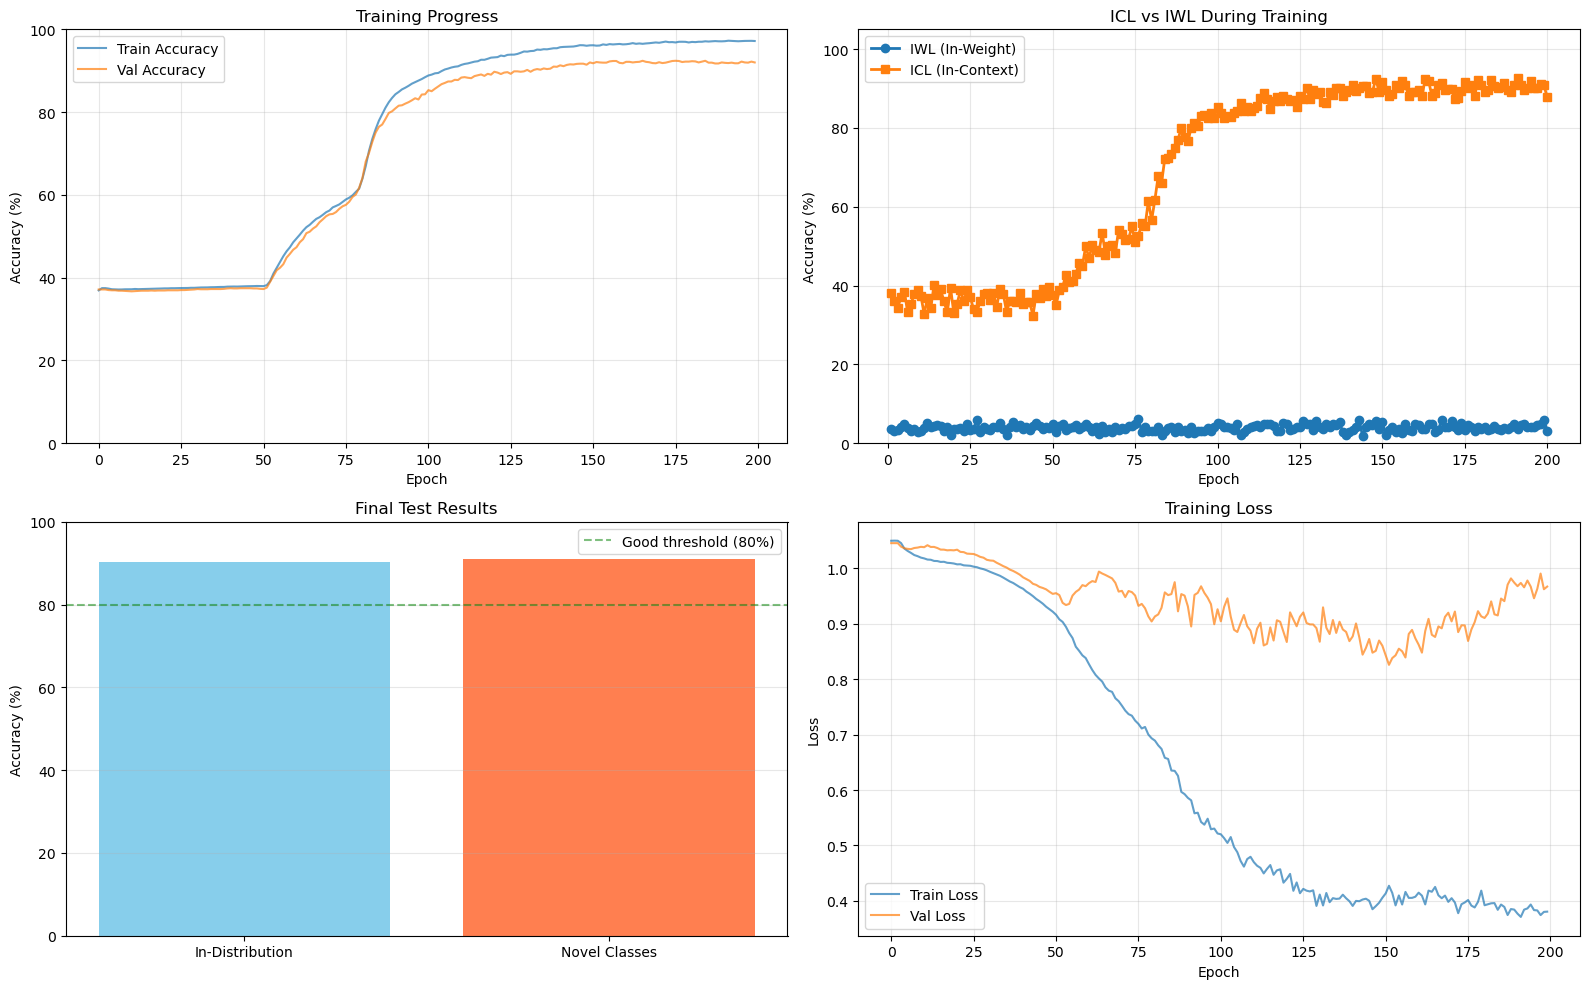


ICL/IWL SUMMARY
Final IWL Accuracy:        3.20%
Final ICL Accuracy:  87.80%


In [ ]:
### Updated to use refactored code structure POLYNOMIAL

# Import from refactored modules
import torch
import numpy as np
import os
import time
from torch.utils.data import DataLoader

# Import from new modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data, generate_iwl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL, RandomPolynomialICL
from training import train_model
from evaluation import test_icl
from config import ExperimentConfig

# L = 32
# K = 256
# D = 32
# N = 8
# B = 2
L = 32
K = 1024
D = 64
N = 6
B = 2
n_nodes = 15
n_vars = 50
M = 50
d = 4
epochs = 200
lr = 0.001
batch_size = 64
train_samples = 10000
val_samples = 2000
epsilon = 1e-4
seed = 42
exact_copy = True
method = 'direct_solve'
temperature = 1.0

# Set parameters
params = {
    'K': K,                      # Number of GMM classes
    'L': L,                      # Number of output classes (can be different from K)
    'D': D,                      # Dimension
    'N': N,                      # Context examples
    'B': B,                      # Burstiness
    'n_nodes': n_nodes,          # Markov nodes
    'n_vars': n_vars,            # Number of variables
    'M' : M,                     # Number of monomials
    'd' : d,                     # Degree of monomials
    'epochs': epochs,            # Training epochs
    'lr': lr,                    # Learning rate
    'batch_size': batch_size,
    'train_samples': train_samples,
    'val_samples': val_samples,
    'epsilon': epsilon,          # Within-class noise
    'seed': seed,
    'exact_copy': exact_copy,    # Query is exact copy of context item
    'method': method,
    'temperature': temperature   # Softmax temperature
}



print("="*70)
print("Polynomial ICL - CLASSIFICATION (Softmax Output)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print(f"Method: {params['method']}, Temperature: {params['temperature']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM with discrete labels (1 to L)
print("Creating GMM with discrete labels...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], L=params['L'], epsilon=params['epsilon'], seed=params['seed'])
print(f"  GMM: {params['K']} classes with labels randomly assigned from {{1, ..., {params['L']}}}")
print(f"  First 10 class labels: {gmm.class_to_label[:min(10, params['K'])].numpy()}")

# Generate data
print("\nGenerating data...")
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'])
val_data = generate_icl_gmm_data(gmm, params['val_samples'], params['N'], 
                                 novel_classes=False, exact_copy=params['exact_copy'], 
                                 B=params['B'], L=params['L'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ICLGMMDataset(val_data), batch_size=params['batch_size'],
                       collate_fn=collate_fn)

# Create model
print("\nCreating model...")
model = RandomPolynomialICL(n_nodes=params['n_nodes'], n_vars = params['n_vars'], z_dim=params['D'], 
                           L=params['L'], N=params['N'], M = params['M'], d = params['d'])

# Train with ICL/IWL tracking
start_time = time.time()
print("\nTraining...")
print("="*70)
history = train_model(model, train_loader, val_loader, device, 
                     n_epochs=params['epochs'], lr=params['lr'], 
                     method=params['method'], temperature=params['temperature'],
                     gmm=gmm, N=params['N'], B=params['B'], 
                     L=params['L'], exact_copy=params['exact_copy'],
                     eval_frequency=1, n_eval_samples=500)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test
results = test_icl(model, gmm, params['N'], device, n_samples=1000, 
                  exact_copy=params['exact_copy'], B=params['B'], 
                  method=params['method'], L=params['L'],
                  temperature=params['temperature'])

try:
    import matplotlib.pyplot as plt
    
    # Extract ICL/IWL metrics (filter out None values)
    epochs_eval = [i+1 for i, val in enumerate(history['iwl_acc']) if val is not None]
    iwl_acc = [val for val in history['iwl_acc'] if val is not None]
    icl_acc = [val for val in history['icl_acc'] if val is not None]
    #icl_swap_acc = [val for val in history['icl_swap_acc'] if val is not None]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Training/Val Accuracy
    ax1 = axes[0, 0]
    ax1.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    ax1.plot(history['val_acc'], label='Val Accuracy', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    
    # Plot 2: ICL vs IWL over time
    ax2 = axes[0, 1]
    if len(iwl_acc) > 0:
        ax2.plot(epochs_eval, iwl_acc, 'o-', label='IWL (In-Weight)', linewidth=2, markersize=6)
        ax2.plot(epochs_eval, icl_acc, 's-', label='ICL (In-Context)', linewidth=2, markersize=6)
        #ax2.plot(epochs_eval, icl_swap_acc, '^-', label='ICL Label Swap', linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('ICL vs IWL During Training')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 105])
    else:
        ax2.text(0.5, 0.5, 'No ICL/IWL data\n(set gmm parameter)', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Plot 3: Final test results
    ax3 = axes[1, 0]
    ax3.bar(['In-Distribution', 'Novel Classes'], 
            [results['in_dist'], results['novel_classes']],
            color=['skyblue', 'coral'])
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Final Test Results')
    ax3.axhline(y=80, color='g', linestyle='--', label='Good threshold (80%)', alpha=0.5)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 100])
    
    # Plot 4: Training/Val Loss
    ax4 = axes[1, 1]
    ax4.plot(history['train_loss'], label='Train Loss', alpha=0.7)
    ax4.plot(history['val_loss'], label='Val Loss', alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.set_title('Training Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if len(iwl_acc) > 0:
        print("\n" + "="*70)
        print("ICL/IWL SUMMARY")
        print("="*70)
        print(f"Final IWL Accuracy:        {iwl_acc[-1]:.2f}%")
        print(f"Final ICL Accuracy:  {icl_acc[-1]:.2f}%")
        #print(f"Final ICL Swap Accuracy:   {icl_swap_acc[-1]:.2f}%")
        print("="*70)
    
except ImportError:
    print("\n(Install matplotlib to see training plots)")

In [22]:
iwl_data[40]

(tensor([[-2.9242e-01,  5.5188e-01, -3.8720e-01,  4.1913e-01,  4.2002e-01,
           7.2672e-01,  2.3346e-01, -3.9167e-01],
         [-2.9248e-01,  5.5186e-01, -3.8717e-01,  4.1916e-01,  4.2000e-01,
           7.2675e-01,  2.3346e-01, -3.9162e-01],
         [-1.0370e-01,  7.4487e-01, -3.8506e-02,  2.1511e-01,  2.7907e-01,
           2.7668e-01, -2.2858e-02, -1.1390e-04],
         [-1.0373e-01,  7.4477e-01, -3.8413e-02,  2.1504e-01,  2.7911e-01,
           2.7668e-01, -2.2881e-02, -9.0079e-05],
         [ 1.1779e-01, -4.4285e-01, -2.0315e-01, -6.7386e-01, -3.4176e-01,
           1.3004e-01, -2.0454e-01,  4.3748e-01]]),
 tensor([15., 15.,  8.,  8.]),
 tensor(6.))

In [ ]:
z_seq, labels, targets = train_loader.dataset[100]

# Add batch dimension and move to device
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)


z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
print(z_flat)
z_flat = torch.tensor([[-2, 1, -2]], dtype=torch.float32)
print(z_flat)
# Compute the rate matrix K
model.eval()
with torch.no_grad():
    K_mat = model.compute_rate_matrix_K(z_flat)
# Verify that columns sum to approximately zero (as they should for a rate matrix)
col_sums = K_mat[0].sum(dim=0)
# p_steady = model.direct_solve_steady_state(K_mat)

p_steady = model.matrix_tree_steady_state(K_mat)
print(p_steady)

p_steady = model.direct_solve_steady_state(K_mat) 
print(p_steady)

# Compute the inner product z_flat @ Amat @ z_flat^T
# z_flat shape: (1, (N+1)*D)
# Amat shape: ((N+1)*D, (N+1)*D)

one_inds = [0,2]
two_inds = [2,1]
three_inds = [0,1]
four_inds = [1,2]
five_inds = [1,0]
six_inds = [2,0]


A1 = model.K_params[one_inds[0],one_inds[1],:].detach().numpy() + model.K_params[two_inds[0],two_inds[1],:].detach().numpy() 
A2 = model.K_params[three_inds[0],three_inds[1],:].detach().numpy() + model.K_params[four_inds[0],four_inds[1],:].detach().numpy()
A3 = model.K_params[one_inds[0],one_inds[1],:].detach().numpy() + model.K_params[three_inds[0],three_inds[1],:].detach().numpy()
B1 = model.K_params[five_inds[0],five_inds[1],:].detach().numpy() + model.K_params[one_inds[0],one_inds[1],:].detach().numpy()
B2 = model.K_params[four_inds[0],four_inds[1],:].detach().numpy() + model.K_params[six_inds[0],six_inds[1],:].detach().numpy()
B3 = model.K_params[four_inds[0],four_inds[1],:].detach().numpy() + model.K_params[five_inds[0],five_inds[1],:].detach().numpy()
C1 = model.K_params[six_inds[0],six_inds[1],:].detach().numpy() + model.K_params[three_inds[0],three_inds[1],:].detach().numpy()
C2 = model.K_params[five_inds[0],five_inds[1],:].detach().numpy() + model.K_params[two_inds[0],two_inds[1],:].detach().numpy()
C3 = model.K_params[six_inds[0],six_inds[1],:].detach().numpy() + model.K_params[two_inds[0],two_inds[1],:].detach().numpy()


piA = np.exp(z_flat @ A1) + np.exp(z_flat @ A2) + np.exp(z_flat @ A3)
piB = np.exp(z_flat @ B1) + np.exp(z_flat @ B2) + np.exp(z_flat @ B3)
piC = np.exp(z_flat @ C1) + np.exp(z_flat @ C2) + np.exp(z_flat @ C3)
Z = piA + piB + piC
piAf = (piA / Z).item()
piBf = (piB / Z).item()
piCf = (piC / Z).item()
print([piAf, piBf, piCf])

# print(K_mat[0])
# print(K_mat[0,0,2] * K_mat[0,2,1])
# print(np.exp(z_flat @ A1))

# print(K_mat[0,0,1] * K_mat[0,1,2])
# print(np.exp(z_flat @ A2))

# print(K_mat[0,1,0] * K_mat[0,0,2])
# print(np.exp(z_flat @ B1))

# print(K_mat[0,1,2] * K_mat[0,2,0])
# print(np.exp(z_flat @ B2))

# print(K_mat[0,2,0] * K_mat[0,0,1])
# print(np.exp(z_flat @ C1))

# print(K_mat[0,2,1] * K_mat[0,1,0])
# print(np.exp(z_flat @ C2))

print(A1)
print(A2)
print(A3)
print(B1)
print(B2)
print(B3)
print(C1)
print(C2)
print(C3)



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create figure and 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d', elev=20, azim=35)

# Define vectors (already computed above)
vectors = {
    'A1': A1, 'A2': A2, 'A3': A3,
    'B1': B1, 'B2': B2, 'B3': B3,
    'C1': C1, 'C2': C2, 'C3': C3
}

# Color mapping by letter
colors = {
    'A': 'red',
    'B': 'blue',
    'C': 'green'
}

# Create plane passing through origin containing {0,1,1}
# The plane needs two vectors: {0,1,1} and we'll choose {1,0,0} as the second
# This defines a plane spanned by these two vectors
v1 = np.array([0, 1, 1])
v2 = np.array([1, 0, 0])

# Create mesh grid for the plane
max_range = np.array([
    max(abs(v[0]) for v in vectors.values()),
    max(abs(v[1]) for v in vectors.values()),
    max(abs(v[2]) for v in vectors.values())
]).max()

t1 = np.linspace(-max_range, max_range, 10)
t2 = np.linspace(-max_range, max_range, 10)
T1, T2 = np.meshgrid(t1, t2)

# Points on the plane: P = t1*v1 + t2*v2
X_plane = T2 * v2[0] + T1 * v1[0]
Y_plane = T2 * v2[1] + T1 * v1[1]
Z_plane = T2 * v2[2] + T1 * v1[2]

alpha_grid = 0.3

# Plot the plane
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=alpha_grid, color='magenta', 
                edgecolor='magenta', linewidth=alpha_grid)


v1 = np.array([1, 0, 1])
v2 = np.array([0, 1, 0])

# Create mesh grid for the plane
max_range = np.array([
    max(abs(v[0]) for v in vectors.values()),
    max(abs(v[1]) for v in vectors.values()),
    max(abs(v[2]) for v in vectors.values())
]).max()

t1 = np.linspace(-max_range, max_range, 10)
t2 = np.linspace(-max_range, max_range, 10)
T1, T2 = np.meshgrid(t1, t2)

# Points on the plane: P = t1*v1 + t2*v2
X_plane = T2 * v2[0] + T1 * v1[0]
Y_plane = T2 * v2[1] + T1 * v1[1]
Z_plane = T2 * v2[2] + T1 * v1[2]

# Plot the plane
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=alpha_grid, color='cyan', 
                edgecolor='cyan', linewidth=alpha_grid)


# Plot each vector as an arrow
for name, vec in vectors.items():
    letter = name[0]  # Get first character (A, B, or C)
    color = colors[letter]
    
    # Draw arrow from origin to vector endpoint
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], 
              color=color,# arrow_length_ratio=0.15, 
              alpha=0.8, label=name)

# Draw the special vector {0,1,1}
ax.quiver(0, 0, 0, 0, 2, 2, 
          color='magenta', #arrow_length_ratio=0.15, 
          alpha=1.0, label='{0,1,1}')

# Draw the special vector {0,1,1}
ax.quiver(0, 0, 0, 2, 0, 2, 
          color='cyan', #arrow_length_ratio=0.15, 
          alpha=1.0, label='{0,1,1}')

# Set labels and title
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.set_title('3D Vector Visualization with Plane containing {0,1,1}', fontsize=14)

# Add legend
ax.legend(loc='upper left', fontsize=9)

# Set equal aspect ratio for better visualization
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

# Add grid
#ax.grid(True, alpha=0.3)

ax.grid(False)

plt.tight_layout()
plt.show()
